# Import Modules

In [1]:
import os
import pandas as pd
import numpy as np
import scipy.optimize as sc 
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import Image
import matplotlib.pyplot as plt


# Data Preprocessing

In [2]:
# # Import data from files
# os.chdir('/Users/talhajamal/Desktop/Code/BigData1Project')
# data = pd.read_csv("data/Returns_Data.csv")
# data['date'] = pd.to_datetime(data['date'], dayfirst=False)
# characteristics = pd.read_csv("data/Stock_Characteristics_Data.csv")
# dictionary = pd.read_excel("data/StockDataDictionary.xlsx")


In [3]:
# Generate simulated data
import random
from sklearn.linear_model import LinearRegression

# Function to compute predicted returns using simple linear regression on the last rebalance period
def compute_predicted_return(df):
    period = 70
    df = df.sort_values('date')
    df['PRED'] = np.nan
    for i in range(period, len(df)):
        X = np.arange(period).reshape(-1, 1)
        y = df['RET'].iloc[i-period:i].values
        model = LinearRegression().fit(X, y)
        df.loc[df.index[i], 'PRED'] = model.predict([[period]])[0]
    return df

seed = 2024
random.seed(seed)
np.random.seed(seed)

# Set tickers and time range
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
date_range = pd.date_range(start='2023-01-01', end= '2023-12-31', freq='B') # only include weekdays

# Generate data
data = []
for date in date_range:
    for ticker in tickers:
        prc = round(random.uniform(100, 1000), 2)
        vol = random.randint(1000, 1000000)
        ret = round(np.random.normal(0, 0.02), 4)
        shrout = random.randint(50000000, 500000000)
        vweretd = round(random.uniform(-0.02, 0.02),4)
        ewretd = round(random.uniform(-0.02, 0.02),4)
        rf = round(np.random.normal(0.0225, 0.005), 4)
        data.append([date, ticker, prc, vol, ret, shrout, vweretd, ewretd, rf])

columns = ['date', 'ticker', 'PRC', 'VOL', 'RET', 'SHROUT', 'vwretd', 'ewretd', 'rf']
data = pd.DataFrame(data, columns=columns)

# Apply the prediction function to each ticker group -> add a simulated prediction
data = data.groupby('ticker').apply(compute_predicted_return)

# show generated data
print(data.shape)
data.tail()

(1300, 10)


C:\Users\kangj\AppData\Local\Temp\ipykernel_24256\1758041697.py:42: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby('ticker').apply(compute_predicted_return)


,date,ticker,PRC,VOL,RET,SHROUT,vwretd,ewretd,rf,PRED
1295,2023-12-29,AAPL,536.66,290061,0.0103,182338031,-0.0145,-0.0102,0.0255,-0.001219
1296,2023-12-29,GOOGL,903.07,320045,0.0012,280766124,0.0061,0.0005,0.0299,0.007690
1297,2023-12-29,MSFT,236.05,317667,0.0078,173414396,0.0092,0.0152,0.0140,-0.005332
1298,2023-12-29,AMZN,226.79,927095,-0.0277,53799145,-0.0164,0.0172,0.0226,0.008966
1299,2023-12-29,TSLA,208.90,274604,0.0107,426211384,-0.0064,0.0150,0.0283,0.005148


In [4]:
# Create new dataframes
prices = data.pivot(index='date', columns='ticker', values='PRC')
volume = data.pivot(index='date', columns='ticker', values='VOL')
returns = data.pivot(index='date', columns='ticker', values='RET')
risk_free_rate = data.pivot(index='date', columns='ticker', values='rf').mean(axis=1)
pred_returns = data.pivot(index='date', columns='ticker', values='PRED')

#returns = returns * 100 # Scale returns to percentage
# Summary of Returns
returns_summary = returns.describe()
shares_outstanding = data.pivot(index='date', columns='ticker', values='SHROUT')
value_weighted_returns = data.pivot(index='date', columns='ticker', values='vwretd')
equal_weighted_returns = data.pivot(index='date', columns='ticker', values='ewretd')
tickers = prices.columns # List of Tickers

# Functions

In [5]:
def portfolioPerformance(weights, meanReturns, covMatrix):
    """ Calculate Portfolio Performance"""
    annualizedReturns = np.sum(meanReturns*weights)*252
    annualizedStd = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(252)
    return annualizedReturns*100, annualizedStd*100

def portfolioVariance(weights, meanReturns, covMatrix):
    """ Return Portfolio Variance """
    return portfolioPerformance(weights, meanReturns, covMatrix)[1]

def portfolioReturn(weights, meanReturns, covMatrix):
    """ Return Portfolio Return """
    return portfolioPerformance(weights, meanReturns, covMatrix)[0]

def negativeSR(weights, meanReturns, covMatrix,riskFreeRate = 0):
    """ Calculate Negative Sharpe so that Optimizer works on it and minimizes it -> essentially maximising it"""
    annualizedRet, annualizedStd = portfolioPerformance(weights, meanReturns, covMatrix)
    return - ((annualizedRet - riskFreeRate)/annualizedStd)

def maxSR(meanReturns, covMatrix, riskFreeRate = 0, constraintSet = (0, 1)):
    """ Minimize the negative Sharpe Ratio -> Maximize it"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type':'eq','fun': lambda x: np.sum(x) - 1 }) # Weights must sum up to 1
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets)) # For every asset have this bound
    result = sc.minimize(negativeSR, x0=numAssets*[1./numAssets], args=args, 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def minimizeVariance(meanReturns, covMatrix, riskFreeRate = 0, constraintSet = (0, 1)):
    """ Minimize the portfolio variance by altering the weights/allocations of assets in the portfolio"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type':'eq','fun': lambda x: np.sum(x) - 1 }) # Weights must sum up to 1
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets)) # For every asset have this bound
    result = sc.minimize(portfolioVariance, x0=numAssets*[1./numAssets], args=args, 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def meanVarianceOptimiser(meanReturns, covMatrix, returnTarget, constraintSet=(0,1)):
    """ For each return target, optimize the portfolio for minimum variance"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type':'eq', 'fun':lambda x: portfolioReturn(x, meanReturns, covMatrix) - returnTarget},
                   {'type':'eq','fun': lambda x: np.sum(x) - 1 }
                   )
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    optimizedResults = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args, 
                                   method='SLSQP', constraints=constraints, bounds=bounds)
    return optimizedResults

def eqWeightPortfolioPerformance(meanReturns, covMatrix, returns):
    """ Return the Performance of an Equally Weighted Portfolio"""
    weights = np.array([1/100 for _ in returns])
    equalWeightedPortfolioReturns, equalWeightedPortfolioVolatility = portfolioPerformance(weights, meanReturns, covMatrix)
    equalWeightedPortfolioSR = (-1) * negativeSR(weights, meanReturns, covMatrix)
    print(f"Equal Weighted Portfolio Returns: {round(equalWeightedPortfolioReturns, 2)} %")
    print(f"Equal Weighted Portfolio Volatility: {round(equalWeightedPortfolioVolatility, 2)} %")
    print(f"Equal Weighted Portfolio SR: {round(equalWeightedPortfolioSR, 2)}")
    return equalWeightedPortfolioReturns, equalWeightedPortfolioVolatility, equalWeightedPortfolioSR
    
def maxSRPortfolioPerformance(meanReturns, covMatrix):
    """ Return the Performance of the Maximum SR Portfolio"""
    maxSRPortfolioPerformance = maxSR(meanReturns, covMatrix)
    maxSRPortfolioWeights = maxSRPortfolioPerformance.x
    maxSRPortfolioReturns, maxSRPortfolioVolatility = portfolioPerformance(maxSRPortfolioWeights, meanReturns, covMatrix)
    maxSRPortfolioSR = maxSRPortfolioPerformance.fun * (-1)
    print(f"Max SR Portfolio Returns: {round(maxSRPortfolioReturns, 2)} %")
    print(f"Max SR Portfolio Volatility: {round(maxSRPortfolioVolatility, 2)} %")
    print(f"Max SR Portfolio SR: {round(maxSRPortfolioSR, 2)}")
    return maxSRPortfolioReturns, maxSRPortfolioVolatility, maxSRPortfolioSR, maxSRPortfolioWeights

def minVariancePortfolioPerformance(meanReturns, covMatrix):
    """ Return the Performance of the Minimum Variance Portfolio"""
    minVariancePortfolioPerformance = minimizeVariance(meanReturns, covMatrix)
    minVariancePortfolioWeights = minVariancePortfolioPerformance.x
    minVariancePortfolioReturns, minVariancePortfolioVolatility = portfolioPerformance(minVariancePortfolioWeights, meanReturns, covMatrix)
    minVariancePortfolioSR = (-1) * negativeSR(minVariancePortfolioWeights, meanReturns, covMatrix)
    print(f"Min Variance Portfolio Returns: {round(minVariancePortfolioReturns, 2)} %")
    print(f"Min Variance Portfolio Volatility: {round(minVariancePortfolioVolatility, 2)} %")
    print(f"Min Variance Portfolio SR: {round(minVariancePortfolioSR, 2)}")
    return minVariancePortfolioReturns, minVariancePortfolioVolatility, minVariancePortfolioSR, minVariancePortfolioWeights

def EF_generator(minVariancePortfolioReturns, maxSRPortfolioReturns, meanReturns, covMatrix):
    """ Generate the List for the Efficient Frontier"""
    targetReturns = np.linspace(minVariancePortfolioReturns, 25, 20)
    efficientFrontier = []
    for target in targetReturns:
        efficientFrontier.append(meanVarianceOptimiser(meanReturns, covMatrix, returnTarget=target)['fun'])
    return efficientFrontier, targetReturns

def EF_graph(meanReturns, covMatrix, riskFreeRate = 0, constraintSet = (0, 1)):
    """ Return a Graph plotting the min vol, max sr, and efficient frontier"""
    
    maxSRPortfolioRet, maxSRPortfolioVol, maxSRPortfolioSR, maxSRPortfolioWeights = maxSRPortfolioPerformance(meanReturns, covMatrix)
    minVarPortfolioRet, minVarPortfolioVol, minVarPortfolioSR, minVariancePortfolioWeights = minVariancePortfolioPerformance(meanReturns, covMatrix)

    efficientList, targetReturns = EF_generator(minVarPortfolioRet, maxSRPortfolioRet, meanReturns, covMatrix)

    # Plot the Equal Weighted Portfolio
    eqWRet, eqWVol, eqWSR = eqWeightPortfolioPerformance(meanReturns, covMatrix, returns)
    eqWeightedPortfolio = go.Scatter(
        name='Equally Weighted Portfolio',
        mode = 'markers',
        x = [eqWVol],
        y = [eqWRet],
        marker = dict(color='yellow', size=14, line=dict(width=3, color='black') )
    )


    # Plot the Max SR
    MaxSharpeRatio = go.Scatter(
        name='Max Sharpe Ratio',
        mode='markers',
        x = [maxSRPortfolioVol],
        y = [maxSRPortfolioRet],
        marker = dict(color='red', size=14, line=dict(width=3, color='black') )
    )

    # Plot the Min vol
    MinVol = go.Scatter(
        name='Min Volatility',
        mode='markers',
        x = [minVarPortfolioVol],
        y = [minVarPortfolioRet],
        marker = dict(color='green', size=14, line=dict(width=3, color='black') )
    )

    # Plot the Efficient Frontier
    EF_curve = go.Scatter(
        name='Efficient Frontier',
        mode='lines',
        x = [round(ef_std, 2) for ef_std in efficientList],
        y = [round(target, 2) for target in targetReturns],
        line = dict(color='black', width=4, dash='dashdot')
    )

    data = [MaxSharpeRatio, MinVol, eqWeightedPortfolio, EF_curve]
    
    layout = go.Layout(
        title = {
            'text':'Comparison of Portfolios via Mean Variance Optimization',
            'y':0.9,
            'x':0.5,
            'xanchor':'center',
            'yanchor':'top'
        },
        yaxis = dict(title='Annualized Returns (%)'),
        xaxis= dict(title='Annualized Volatility (%)'),
        showlegend= True,
        legend= dict(
                    x=0.7, 
                    y=0, 
                    traceorder='normal', 
                    bgcolor='#E2E2E2', 
                    bordercolor='black', 
                    borderwidth=2),
        width=800,
        height=600)
    
    fig = go.Figure(data=data, layout=layout)

    pio.write_image(fig, 'MeanVariancePortfolioOptimization.png')

    return fig.show()

# Mean Returns and CovMatrix

In [6]:
meanReturns = returns.mean()
covMatrix = returns.cov()

# Equal Weighted Portfolio

In [7]:
equalWeightedPortfolioRet, equalWeightedPortfolioVol, equalWeightedPortfolioSR = eqWeightPortfolioPerformance(meanReturns, 
                                                                                                              covMatrix, 
                                                                                                              returns)

Equal Weighted Portfolio Returns: 0.29 %
Equal Weighted Portfolio Volatility: 0.67 %
Equal Weighted Portfolio SR: 0.44


# Max SR Portfolio

In [8]:
maxSRPortfolioRet, maxSRPortfolioVol, maxSRPortfolioSR, maxSRPortfolioWeights = maxSRPortfolioPerformance(meanReturns, covMatrix)

Max SR Portfolio Returns: 28.98 %
Max SR Portfolio Volatility: 23.41 %
Max SR Portfolio SR: 1.24


# Min Variance Portfolio

In [9]:
minVarPortfolioRet, minVarPortfolioVol, minVarPortfolioSR, minVariancePortfolioWeights = minVariancePortfolioPerformance(meanReturns, covMatrix)

Min Variance Portfolio Returns: 4.48 %
Min Variance Portfolio Volatility: 13.29 %
Min Variance Portfolio SR: 0.34


# Backtest

## Functions

In [25]:
# Update portfolio weights daily based on past period historical data
# Update portfolio weights daily based on past 70 days' historical data
def update_weights(data, pred_returns, method, risk_free_rate):
    dates = data.index.unique()
    tickers = data.columns
    weights = pd.DataFrame(index=dates, columns=tickers).fillna(0)
    
    for i in range(70, len(dates)-1):
        past_data = data.iloc[i-70:i]
        meanReturns = past_data.mean()
        covMatrix = past_data.cov()
        rf = risk_free_rate.iloc[i]
        pred_return_next_day = pred_returns.iloc[i+1]
        
        if method == 'max_sr':
            result = maxSR(meanReturns, covMatrix, rf)
        elif method == 'min_var':
            result = minimizeVariance(meanReturns, covMatrix)
        elif method == 'pred_mean_var':
            combined_mean_returns = (meanReturns + pred_return_next_day) / 2
            result = maxSR(combined_mean_returns, covMatrix, rf)
            
#         if method != 'pred_mean_var' and np.all(pred_return_next_day < rf):
#             weights.iloc[i] = np.zeros(len(tickers))
#         else:
#             weights.iloc[i] = result.x
            
        weights.iloc[i] = result.x
    
    return weights

# Backtest
def backtest(weights, returns, initial_capital):
    portfolio_values = [initial_capital]
    for date in returns.index[1:]:
        prev_value = portfolio_values[-1]
        daily_return = np.sum(weights.loc[date] * returns.loc[date])
        portfolio_values.append(prev_value * (1 + daily_return))
    return portfolio_values


## Generate weights

In [26]:
# Generate weights for max SR, min variance, and mean-variance optimization using predicted returns
max_sr_weights = update_weights(returns, pred_returns, 'max_sr', risk_free_rate)
min_var_weights = update_weights(returns, pred_returns, 'min_var', risk_free_rate)
pred_mean_var_weights = update_weights(returns, pred_returns, 'pred_mean_var', risk_free_rate)

# Generate weights for equally weighted portfolio
equal_weights = pd.DataFrame(1/len(tickers), index=returns.index, columns=tickers)


In [27]:
max_sr_weights.tail()

ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
date,,,,,
2023-12-25,3.700110e-16,0.396547,0.084010,0.519443,0.000000e+00
2023-12-26,0.000000e+00,0.369685,0.136510,0.493805,1.431645e-15
2023-12-27,0.000000e+00,0.389894,0.164151,0.445955,2.269676e-16
2023-12-28,0.000000e+00,0.413696,0.165368,0.420936,3.104415e-16
2023-12-29,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00


In [28]:
min_var_weights.tail()

ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
date,,,,,
2023-12-25,0.243874,0.229115,0.102609,0.234502,0.189900
2023-12-26,0.241231,0.217799,0.104396,0.228891,0.207682
2023-12-27,0.220896,0.233518,0.098848,0.228359,0.218378
2023-12-28,0.226377,0.234304,0.098049,0.221429,0.219842
2023-12-29,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
pred_mean_var_weights.tail()

ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
date,,,,,
2023-12-25,6.035563e-16,0.541044,0.065592,1.977130e-01,0.195652
2023-12-26,0.000000e+00,0.461157,0.140126,1.924464e-01,0.206271
2023-12-27,0.000000e+00,0.459139,0.178553,1.703487e-01,0.191959
2023-12-28,0.000000e+00,0.475079,0.326947,9.263466e-17,0.197973
2023-12-29,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000


## Perform Backtest

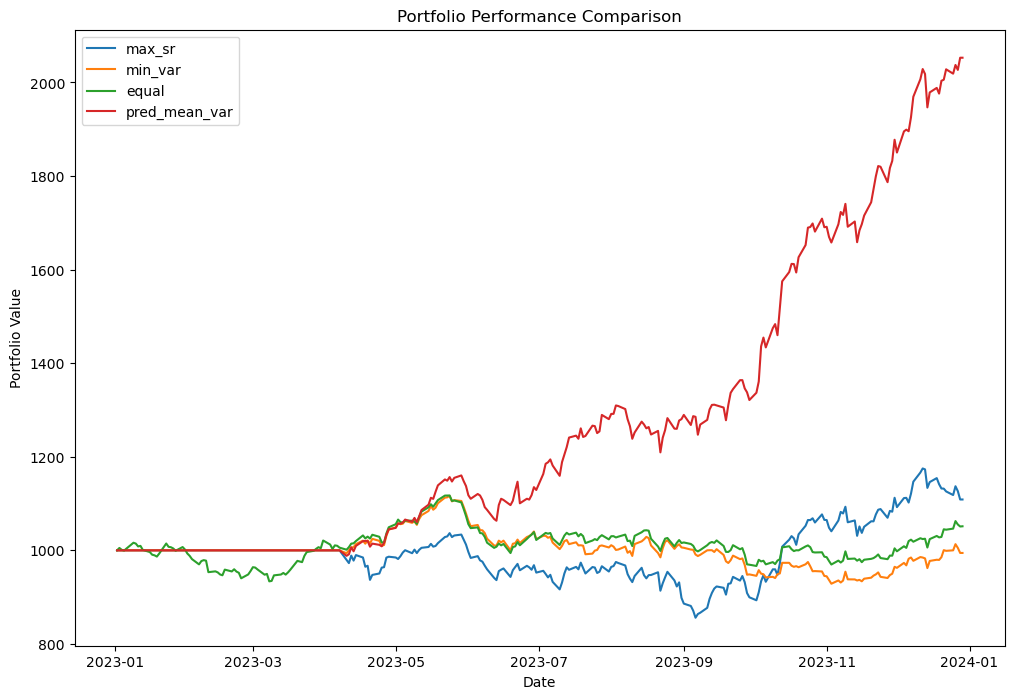

In [30]:
# Backtest portfolios
initial_capital = 1000
portfolios = {
    'max_sr': max_sr_weights,
    'min_var': min_var_weights,
    'equal': equal_weights,
    'pred_mean_var': pred_mean_var_weights
}

# Perform backtest
results = {}
for name, weights in portfolios.items():
    results[name] = backtest(weights, returns, initial_capital)

# Plot results
plt.figure(figsize=(12, 8))
for name, values in results.items():
    plt.plot(returns.index, values, label=name)
plt.title('Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# Efficient Frontier

In [16]:
# !pip install -U kaleido
import kaleido

In [17]:
EF_graph(meanReturns, covMatrix)

Max SR Portfolio Returns: 165.06 %
Max SR Portfolio Volatility: 57.18 %
Max SR Portfolio SR: 2.89
Min Variance Portfolio Returns: 77.84 %
Min Variance Portfolio Volatility: 39.9 %
Min Variance Portfolio SR: 1.95
Equal Weighted Portfolio Returns: 3.78 %
Equal Weighted Portfolio Volatility: 2.01 %
Equal Weighted Portfolio SR: 1.88


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [13]:
# Display the PNG image file
Image(filename='MeanVariancePortfolioOptimization.png')

FileNotFoundError: [Errno 2] No such file or directory: 'MeanVariancePortfolioOptimization.png'